# Fayette County E-Scooters & Bicycles Data Exploration

This project is devoted to exploring data related to collisions, injuries, and deaths between bicycles and scooters since the beginning of the Fayette County E-Scooter Project in the spring of 2018. Data analysis including charts will be used to explore the datasets provided by the Lexington Fayette County Data and Analysis Department. Note that two separate datasets were compiled and sent from the LFPD. One concerns data entries solely related to 'e-scooter' searches as well as one for 'bicycle' searches. The second database is the comprehensive list of bicycle and e-scooter-related police reports concerning collisions and injuries. 

The LFPD has some notes that should be made clear concerning this data. One, it was impossible to determine "motor-scooters" from "e-scooters". This means that injuries related to e-scooters are roped in with general motor scooters, so it's difficult to determine if they come from commercial brands like Lime/Bird or are private motor scooters. Two, the lat/lng points of collisions have been censored and are triangulated to the nearest intersection. This gives privacy to involved parties and protects their identities. 

## Table of Contents 
### 1. Loading Libraries, Data, DataFrames
### 2. DataFrame Cleanup & Exploration
### 3. Conclusions

## Pt. 1: Loading Libraries, Data, DataFrames

In [1]:
import re
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, time

In [2]:
# set dataframe to options for row and column widths 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [57]:
# load data from csv files provided by Lexington-Fayette Police Department 

# first, the narrative searches for 'bicycle' or 'scooter' collisions data
bicycle_collisions_narrative = pd.read_csv('../data/csv/LFPD_data/bicycle_narrative_search.csv')
scooter_collisions_narrative = pd.read_csv('../data/csv/LFPD_data/scooter_narrative_search.csv')



In [4]:
# next, the full bicycle and scooter collision data 
bicycles_all_collisions = pd.read_csv('../data/csv/LFPD_data/all_collision_bicycles.csv')
scooters_all_collisions = pd.read_csv('../data/csv/LFPD_data/all_collision_scooters.csv')


In [5]:
# Create DataFrames 
# for scooters
scooter_search = pd.DataFrame(scooter_collisions_narrative)
all_scooter = pd.DataFrame(scooters_all_collisions)

# for bicycles
bicycle_search = pd.DataFrame(bicycle_collisions_narrative)
all_bicycle = pd.DataFrame(bicycles_all_collisions)

## Pt. 2: Database Cleanup
### Initial Exploration and DataFrame Wrangling

### All Scooters Data

Let's begin with examining the entire scooters database and look at the data

In [6]:
# print the dfa
all_scooter

,MFN,DATE,TIME,DOW,STR#,DIR,ROADWAY,SUF,MP,LATITUDE,LONGITUDE,INTERSECTION,#UNITS,#VEH#,#KILL,#INJURED,WEATHER,RD\COND,H&R,DIRECTIONAL ANALYSIS,MANNER,RDCHAR,LIGHT COND
0,72361205,6/2/2019,2037,Sunday,NaN,NaN,TATES CREEK,RD,7.312,37.962833,-84.494582,CLEARWATER WAY,2,2,0,1,CLEAR,DRY,False,OTHER INTERSECTION COLLISIONS,REAR END,STRAIGHT & GRADE,DAYLIGHT
1,72365079,6/10/2019,2113,Monday,NaN,NaN,DE ROODE,ST,0.341,38.049801,-84.512039,NaN,2,2,0,0,CLEAR,DRY,False,1 VEHICLE PARKED POSITION (NOT PARKING LOT/DRIVEWAY),REAR END,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON
2,72375575,7/4/2019,1814,Thursday,NaN,NaN,VILLAGE,DR,0.311,38.048873,-84.549215,DEVONPORT DR,2,2,0,1,CLEAR,DRY,True,ANGLE COLLISION - OTHER,ANGLE,STRAIGHT & LEVEL,DAYLIGHT
3,72378150,7/11/2019,1440,Thursday,NaN,NaN,ALEXANDRIA,DR,4.104,38.031740,-84.548859,LANE ALLEN RD,1,1,0,1,CLEAR,DRY,False,OTHER INTERSECTION COLLISIONS,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT
4,72383937,7/24/2019,2154,Wednesday,NaN,NaN,CAULDER,RD,0.128,37.978714,-84.482379,HOT SPRINGS CT,2,2,0,1,CLEAR,DRY,False,ANGLE COLLISION - ONE VEHICLE TURNING LEFT,ANGLE,STRAIGHT & GRADE,DARK-HWY LIGHTED/ON
5,72392613,8/13/2019,1248,Tuesday,NaN,NaN,LIBERTY,RD,0.670,38.034993,-84.461202,NaN,1,1,0,1,CLEAR,DRY,False,COLLISION WITH FIXED OBJECT NON - INTERSECTION - FIRST EVENT COLLISION 09 - 32 EXCLUDING 16,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT
6,72399462,8/28/2019,605,Wednesday,NaN,NaN,SARON,DR,0.009,37.968155,-84.502516,MAN O WAR BLVD,1,1,0,0,CLEAR,WET,False,COLLISION WITH FIXED OBJECT IN INTERSECTION - FIRST EVENT COLLISION 09 - 32,SINGLE VEHICLE,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON
7,72401902,9/3/2019,1016,Tuesday,NaN,NaN,EASTLAND,DR,0.711,38.045986,-84.454248,NEW CIRCLE RD,1,1,0,1,CLEAR,DRY,False,OTHER INTERSECTION COLLISIONS,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT
8,72408907,9/18/2019,1812,Wednesday,3000.0,NaN,TATES CREEK,RD,9.588,37.993517,-84.495352,NaN,2,2,0,0,CLEAR,DRY,True,COLLISION IN PARKING LOT,REAR END,STRAIGHT & LEVEL,DAYLIGHT
9,72409859,9/20/2019,1700,Friday,NaN,E,LOUDON,AVE,0.512,38.051769,-84.475228,SHROPSHIRE AVE,2,2,0,1,CLEAR,DRY,True,REAR END - ONE VEHICLE TURNING LEFT,REAR END,STRAIGHT & LEVEL,DAYLIGHT


In [7]:
## now let's look at the scooter info including Dtypes, number  
all_scooter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MFN                   94 non-null     int64  
 1   DATE                  94 non-null     object 
 2   TIME                  94 non-null     int64  
 3   DOW                   94 non-null     object 
 4   STR#                  14 non-null     float64
 5   DIR                   22 non-null     object 
 6   ROADWAY               94 non-null     object 
 7   SUF                   84 non-null     object 
 8   MP                    91 non-null     float64
 9   LATITUDE              94 non-null     float64
 10  LONGITUDE             94 non-null     float64
 11  INTERSECTION          39 non-null     object 
 12  #UNITS                94 non-null     int64  
 13  #VEH#                 94 non-null     int64  
 14  #KILL                 94 non-null     int64  
 15  #INJURED              94 

In [8]:
## rename columns to be more friendly 
all_scooter.rename(columns = {'#Units': 'Units', 'RD\COND':'Road_cond', 'H&R':'HitAndRun', 'DOW':'DoW', '#KILL':'Killed', '#INJURED':'Injured', '#VEH#':'NumberVehicles', 'DIRECTIONAL ANALYSIS':'Direction'}, inplace=True)

In [9]:
# what are the counts of different fields?
all_scooter.HitAndRun.value_counts()

False    69
True     25
Name: HitAndRun, dtype: int64

#### Average number of hit and runs involving motorized scooters for Fayette County

**True (25) / False (69) = 0.3623**

wow! ~36% of scooter injuries are hit and runs. 
That seems a little high, but maybe we should compare this number to other national averages later for this project. 

Next, let's take a look at the weather conditions involved with scooter collisions here in Lexington. Do wet conditions have any effect on the number of collisions?:




In [10]:
# what are the different values/counts for road conditions with scooters?
all_scooter.Road_cond.value_counts()


DRY      85
WET       8
OTHER     1
Name: Road_cond, dtype: int64

Interesting. Most scooter collisions take place during dry road conditions. It seems likely that people do not use scooters in Lexington during rainstorms. :D Or better yet, wet road conditions have little effect on the number of incidents. And why is there one 'other' condition? It's likely debris in the road or some other outlier reason that would affect road conditions. 

Next, I'm going to check against the weather field value counts and see how they correspond with the road conditions.

In [11]:
# Let's go over the weather data field next. See if there is a correlation between weather and wet road conditions
all_scooter.WEATHER.value_counts()

CLEAR      74
CLOUDY     13
RAINING     6
OTHER       1
Name: WEATHER, dtype: int64

Text(0.5, 1.0, '# of Motorized Scooter Collisions by Weather Conditions')

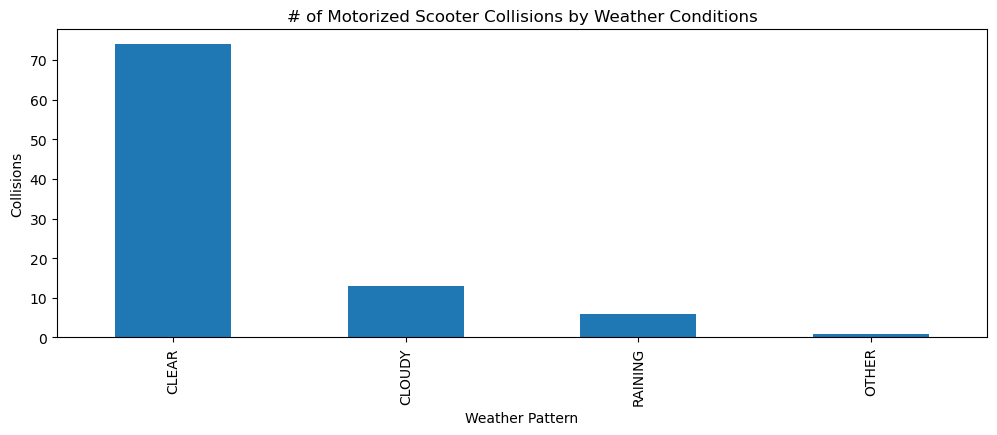

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
all_scooter.WEATHER.value_counts().plot.bar()
ax.set_xlabel('Weather Pattern',)
ax.set_ylabel('Collisions' )
ax.set_title('# of Motorized Scooter Collisions by Weather Conditions')

Looks like the weather patterns correspond roughly to the road conditions. There are 8 wet road condition collisions and that corresponds with the roughly 6 weather conditions described in the police report. We can safely say that weather and road conditions do not showcase any leading causal data to related to the frequency of Lexington's motorized scooter incidents.

But right now, I am more concerned with the injury/death data and would like to move forward with that. Before we finish the analysis, let's remember to convert the csv to a geoDataFrame with Lat/long values as the geometries. 

Next, let's take a look at injuries counts.

In [13]:
# Check the values for number of injuries  
all_scooter.Injured.values

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0,
       1, 0, 0, 0, 1, 1], dtype=int64)

In [14]:
# What are the counts of these numbers?
all_scooter.Injured.value_counts()

1    49
0    39
2     6
Name: Injured, dtype: int64

Looks like there are about ten more single injury-related collisions as non-injury. About 7% of all collisions with motor scooters result in 2 injuries. 

Text(0.5, 1.0, '# of Motorized Scooter Collisions by Day of Week in Lexington, KY')

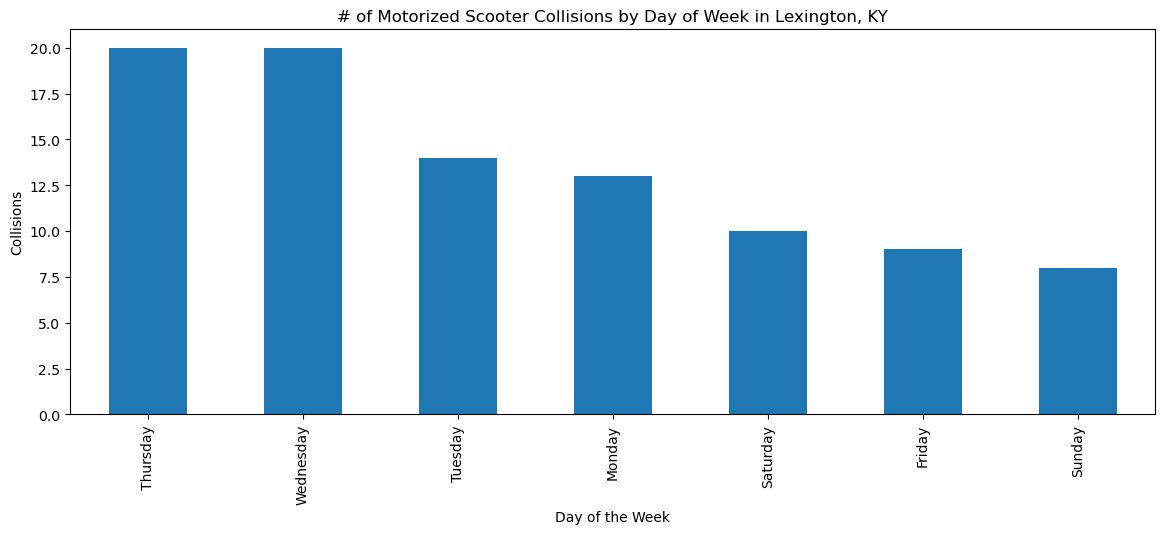

In [15]:
fig, ax = plt.subplots(figsize=(14, 5))
all_scooter.DoW.value_counts().plot.bar()
ax.set_xlabel('Day of the Week',)
ax.set_ylabel('Collisions' )
ax.set_title('# of Motorized Scooter Collisions by Day of Week in Lexington, KY')

Collisions with motorized scooters most frequently take place on Thursday and Wednesday. There are roughly 6-8 more collisions on those days compared to Tuesday and Monday with even less frequency over the weekend. That's surprising because I would have thought weekends had more collision-related incidents due to more people off of work and on the roads. It would be interesting to look into why Wednesdays and Thursdays tend to be more prominent. 

In [16]:
all_scooter.Killed.value_counts()

0    91
1     3
Name: Killed, dtype: int64

In [17]:
# Looks like only three scooter collisions have resulted in death since 2018.

# Only ~3% of collisions result in death here in Lexington

3 / 94

0.031914893617021274

In [18]:
# Next, let's check the roadways and see which ones are the most common 
all_scooter.ROADWAY.values

array(['TATES CREEK', 'DE ROODE', 'VILLAGE', 'ALEXANDRIA', 'CAULDER',
       'LIBERTY', 'SARON', 'EASTLAND', 'TATES CREEK', 'LOUDON',
       'PASADENA', 'TATES CREEK', 'LOWRY', 'PINE', 'WINCHESTER',
       'SUMMITT AT FRITZ FARM', 'VIRGINIA', 'RICHMOND', 'GEORGETOWN',
       'WINCHESTER', 'VERSAILLES', 'VERSAILLES', 'ARMSTRONG MILL',
       'HISLE', 'VERSAILLES', 'SHAFTSBURY', 'VERSAILLES', 'BROADWAY',
       'LEESTOWN', 'CLAY', 'BEAUMONT CENTRE', 'NEW CIRCLE', 'WILLY',
       'CENTRE', 'NEW CIRCLE', 'GOODWIN', 'LOUDON', '7TH', 'EASTLAND',
       'OLD RICHMOND', 'HORSEMANS', 'GEORGETOWN', 'DOUGLAS', 'MAPLE',
       'CITATION', 'WINCHESTER', 'MAIN', 'NICHOLASVILLE', 'VERSAILLES',
       'KINGTREE', '2ND', 'MAIN', 'SHAWNEE', 'TATES CREEK', 'CHINOE',
       'NEW CIRCLE', 'SPRING RUN', 'CORRAL', '3RD', 'TATES CREEK',
       'BROADWAY', 'LIMESTONE', 'BROADWAY', 'RADCLIFFE', 'BROADWAY',
       'LEESTOWN', 'LIMESTONE', 'LANE ALLEN', 'RICHMOND', 'BROADWAY',
       'INDUSTRY', 'BROADWAY', 'LIME

In [19]:
all_scooter['road_counts'] = all_scooter.ROADWAY.value_counts()

Text(0.5, 1.0, '# of Motorized Scooter Collisions by Roadway in Lexington, KY')

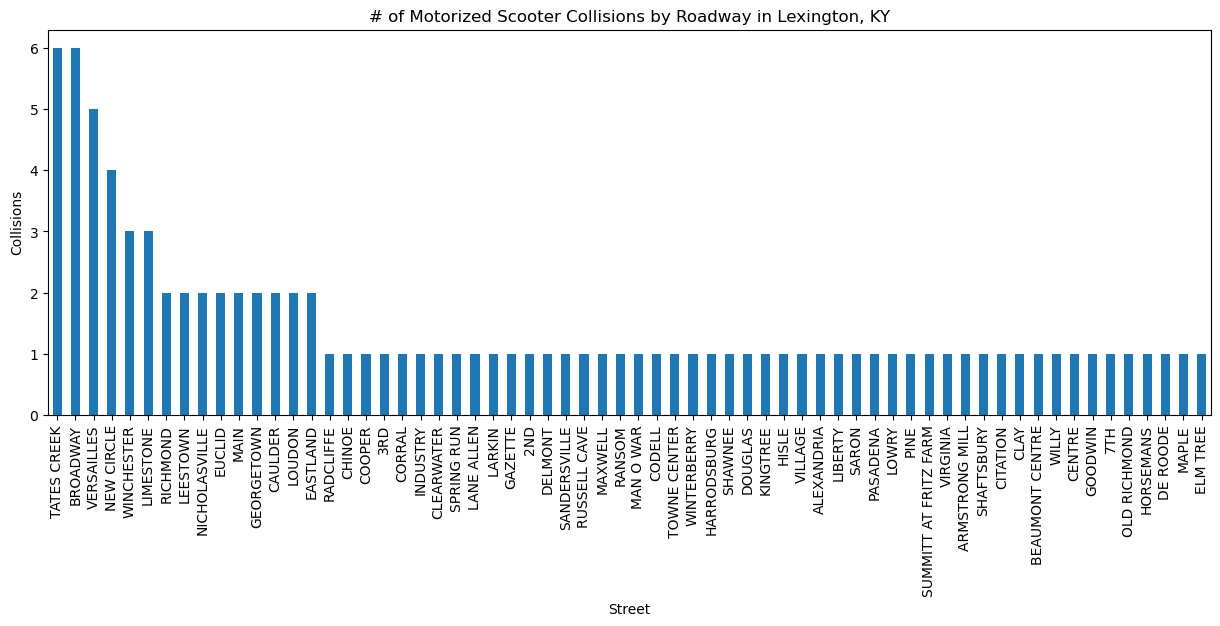

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
all_scooter.ROADWAY.value_counts().plot.bar()
ax.set_xlabel('Street',)
ax.set_ylabel('Collisions' )
ax.set_title('# of Motorized Scooter Collisions by Roadway in Lexington, KY')

The highest amount of collisions take place on Tates Creek, Broadway, Versailles Road, New Circle, Winchester Road respectively. We can come back to this later with a map to interogate locations where collisions take place. Let's move on and look at the months of the year that scooter injuries take place. Our hypothesis is that scooter injuries take place more often during the school season, and UK likely has an affect on the frequency of injuries. Of course, this is just a hypothesis for now, but we should consider this element going forward in studying the age range for collisions involving students and other youthful victims. 

2    71
1    21
4     1
3     1
Name: NumberVehicles, dtype: int64

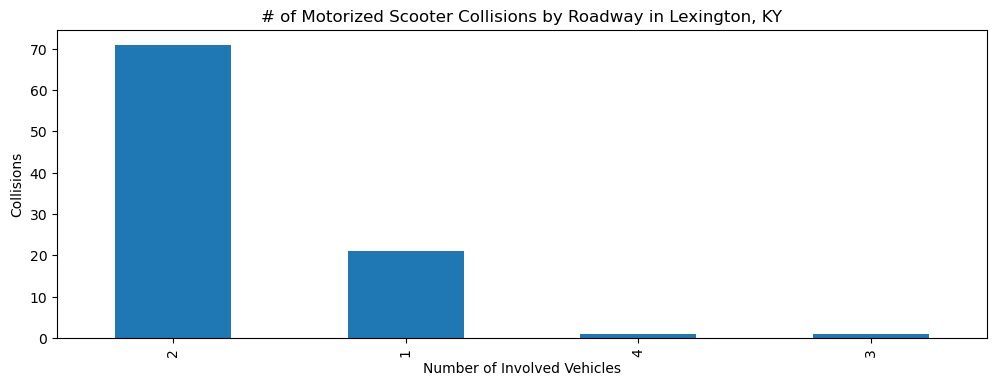

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))
all_scooter.NumberVehicles.value_counts().plot.bar()
ax.set_xlabel('Number of Involved Vehicles')
ax.set_ylabel('Collisions' )
ax.set_title('# of Motorized Scooter Collisions by Roadway in Lexington, KY')

all_scooter.NumberVehicles.value_counts()

In [22]:
all_scooter

,MFN,DATE,TIME,DoW,STR#,DIR,ROADWAY,SUF,MP,LATITUDE,LONGITUDE,INTERSECTION,#UNITS,NumberVehicles,Killed,Injured,WEATHER,Road_cond,HitAndRun,Direction,MANNER,RDCHAR,LIGHT COND,road_counts
0,72361205,6/2/2019,2037,Sunday,NaN,NaN,TATES CREEK,RD,7.312,37.962833,-84.494582,CLEARWATER WAY,2,2,0,1,CLEAR,DRY,False,OTHER INTERSECTION COLLISIONS,REAR END,STRAIGHT & GRADE,DAYLIGHT,NaN
1,72365079,6/10/2019,2113,Monday,NaN,NaN,DE ROODE,ST,0.341,38.049801,-84.512039,NaN,2,2,0,0,CLEAR,DRY,False,1 VEHICLE PARKED POSITION (NOT PARKING LOT/DRIVEWAY),REAR END,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON,NaN
2,72375575,7/4/2019,1814,Thursday,NaN,NaN,VILLAGE,DR,0.311,38.048873,-84.549215,DEVONPORT DR,2,2,0,1,CLEAR,DRY,True,ANGLE COLLISION - OTHER,ANGLE,STRAIGHT & LEVEL,DAYLIGHT,NaN
3,72378150,7/11/2019,1440,Thursday,NaN,NaN,ALEXANDRIA,DR,4.104,38.031740,-84.548859,LANE ALLEN RD,1,1,0,1,CLEAR,DRY,False,OTHER INTERSECTION COLLISIONS,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT,NaN
4,72383937,7/24/2019,2154,Wednesday,NaN,NaN,CAULDER,RD,0.128,37.978714,-84.482379,HOT SPRINGS CT,2,2,0,1,CLEAR,DRY,False,ANGLE COLLISION - ONE VEHICLE TURNING LEFT,ANGLE,STRAIGHT & GRADE,DARK-HWY LIGHTED/ON,NaN
5,72392613,8/13/2019,1248,Tuesday,NaN,NaN,LIBERTY,RD,0.670,38.034993,-84.461202,NaN,1,1,0,1,CLEAR,DRY,False,COLLISION WITH FIXED OBJECT NON - INTERSECTION - FIRST EVENT COLLISION 09 - 32 EXCLUDING 16,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT,NaN
6,72399462,8/28/2019,605,Wednesday,NaN,NaN,SARON,DR,0.009,37.968155,-84.502516,MAN O WAR BLVD,1,1,0,0,CLEAR,WET,False,COLLISION WITH FIXED OBJECT IN INTERSECTION - FIRST EVENT COLLISION 09 - 32,SINGLE VEHICLE,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON,NaN
7,72401902,9/3/2019,1016,Tuesday,NaN,NaN,EASTLAND,DR,0.711,38.045986,-84.454248,NEW CIRCLE RD,1,1,0,1,CLEAR,DRY,False,OTHER INTERSECTION COLLISIONS,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT,NaN
8,72408907,9/18/2019,1812,Wednesday,3000.0,NaN,TATES CREEK,RD,9.588,37.993517,-84.495352,NaN,2,2,0,0,CLEAR,DRY,True,COLLISION IN PARKING LOT,REAR END,STRAIGHT & LEVEL,DAYLIGHT,NaN
9,72409859,9/20/2019,1700,Friday,NaN,E,LOUDON,AVE,0.512,38.051769,-84.475228,SHROPSHIRE AVE,2,2,0,1,CLEAR,DRY,True,REAR END - ONE VEHICLE TURNING LEFT,REAR END,STRAIGHT & LEVEL,DAYLIGHT,NaN


In [23]:
# create a geodataframe and assign the lat/long fields as coordinates 
all_scooter_gdf = gpd.GeoDataFrame(all_scooter, geometry=gpd.points_from_xy(all_scooter.LONGITUDE, all_scooter.LATITUDE))

In [24]:
all_scooter_gdf

,MFN,DATE,TIME,DoW,STR#,DIR,ROADWAY,SUF,MP,LATITUDE,LONGITUDE,INTERSECTION,#UNITS,NumberVehicles,Killed,Injured,WEATHER,Road_cond,HitAndRun,Direction,MANNER,RDCHAR,LIGHT COND,road_counts,geometry
0,72361205,6/2/2019,2037,Sunday,NaN,NaN,TATES CREEK,RD,7.312,37.962833,-84.494582,CLEARWATER WAY,2,2,0,1,CLEAR,DRY,False,OTHER INTERSECTION COLLISIONS,REAR END,STRAIGHT & GRADE,DAYLIGHT,NaN,POINT (-84.49458 37.96283)
1,72365079,6/10/2019,2113,Monday,NaN,NaN,DE ROODE,ST,0.341,38.049801,-84.512039,NaN,2,2,0,0,CLEAR,DRY,False,1 VEHICLE PARKED POSITION (NOT PARKING LOT/DRIVEWAY),REAR END,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON,NaN,POINT (-84.51204 38.04980)
2,72375575,7/4/2019,1814,Thursday,NaN,NaN,VILLAGE,DR,0.311,38.048873,-84.549215,DEVONPORT DR,2,2,0,1,CLEAR,DRY,True,ANGLE COLLISION - OTHER,ANGLE,STRAIGHT & LEVEL,DAYLIGHT,NaN,POINT (-84.54921 38.04887)
3,72378150,7/11/2019,1440,Thursday,NaN,NaN,ALEXANDRIA,DR,4.104,38.031740,-84.548859,LANE ALLEN RD,1,1,0,1,CLEAR,DRY,False,OTHER INTERSECTION COLLISIONS,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT,NaN,POINT (-84.54886 38.03174)
4,72383937,7/24/2019,2154,Wednesday,NaN,NaN,CAULDER,RD,0.128,37.978714,-84.482379,HOT SPRINGS CT,2,2,0,1,CLEAR,DRY,False,ANGLE COLLISION - ONE VEHICLE TURNING LEFT,ANGLE,STRAIGHT & GRADE,DARK-HWY LIGHTED/ON,NaN,POINT (-84.48238 37.97871)
5,72392613,8/13/2019,1248,Tuesday,NaN,NaN,LIBERTY,RD,0.670,38.034993,-84.461202,NaN,1,1,0,1,CLEAR,DRY,False,COLLISION WITH FIXED OBJECT NON - INTERSECTION - FIRST EVENT COLLISION 09 - 32 EXCLUDING 16,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT,NaN,POINT (-84.46120 38.03499)
6,72399462,8/28/2019,605,Wednesday,NaN,NaN,SARON,DR,0.009,37.968155,-84.502516,MAN O WAR BLVD,1,1,0,0,CLEAR,WET,False,COLLISION WITH FIXED OBJECT IN INTERSECTION - FIRST EVENT COLLISION 09 - 32,SINGLE VEHICLE,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON,NaN,POINT (-84.50252 37.96815)
7,72401902,9/3/2019,1016,Tuesday,NaN,NaN,EASTLAND,DR,0.711,38.045986,-84.454248,NEW CIRCLE RD,1,1,0,1,CLEAR,DRY,False,OTHER INTERSECTION COLLISIONS,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT,NaN,POINT (-84.45425 38.04599)
8,72408907,9/18/2019,1812,Wednesday,3000.0,NaN,TATES CREEK,RD,9.588,37.993517,-84.495352,NaN,2,2,0,0,CLEAR,DRY,True,COLLISION IN PARKING LOT,REAR END,STRAIGHT & LEVEL,DAYLIGHT,NaN,POINT (-84.49535 37.99352)
9,72409859,9/20/2019,1700,Friday,NaN,E,LOUDON,AVE,0.512,38.051769,-84.475228,SHROPSHIRE AVE,2,2,0,1,CLEAR,DRY,True,REAR END - ONE VEHICLE TURNING LEFT,REAR END,STRAIGHT & LEVEL,DAYLIGHT,NaN,POINT (-84.47523 38.05177)


In [25]:
all_scooter_gdf.to_file('all_scooter_collisions.shp')

C:\Users\talia\miniconda3\envs\scooters\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\talia\AppData\Local\Temp\ipykernel_19836\3142108218.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  all_scooter_gdf.to_file('all_scooter_collisions.shp')


## Scooter Narrative Search Database

In [26]:
# set the index row 1 as header for pandas dataframe column
scooter_collisions_narrative.columns = scooter_collisions_narrative.iloc[0]

# remove the first row that has the old column names 
scooter_collisions_narrative = scooter_collisions_narrative[1:]

# print the df
scooter_collisions_narrative

,MFN,DATE,TIME,DOW,STR#,DIR,ROADWAY,SUF,MP,LATITUDE,LONGITUDE,INTERSECTION,#UNITS,#VEH#,#KILL,#INJURED,WEATHER,RD\COND,H&R,DIRECTIONAL ANALYSIS,MANNER,RDCHAR,LIGHT COND
1,72375575,7/4/19,1814,Thursday,NaN,NaN,VILLAGE,DR,0.311,38.04887251,-84.54921499,DEVONPORT DR,2,2,0,1,CLEAR,DRY,true,ANGLE COLLISION - OTHER,ANGLE,STRAIGHT & LEVEL,DAYLIGHT
2,72387418,8/1/19,0814,Thursday,NaN,NaN,ALUMNI,DR,1.825,38.00716915,-84.48722702,OLD MT TABOR RD,2,2,0,0,CLEAR,DRY,false,OPPOSING LEFT TURN,OPPOSING LEFT TURN,CURVE & GRADE,DAYLIGHT
3,72392613,8/13/19,1248,Tuesday,NaN,NaN,LIBERTY,RD,0.67,38.03499327,-84.46120239,NaN,1,1,0,1,CLEAR,DRY,false,COLLISION WITH FIXED OBJECT NON - INTERSECTION - FIRST EVENT COLLISION 09 - 32 EXCLUDING 16,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT
4,72419029,10/10/19,1943,Thursday,NaN,NaN,PINE,ST,0.075,38.04346996,-84.50320753,UPPER ST,2,2,0,2,CLEAR,DRY,false,OPPOSING LEFT TURN,OPPOSING LEFT TURN,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON
5,72425069,10/23/19,1518,Wednesday,NaN,NaN,VIRGINIA,AVE,0.024,38.0350012,-84.50874376,NaN,2,2,0,0,CLEAR,DRY,true,HEAD-ON COLLISION,HEAD ON,STRAIGHT & LEVEL,DAYLIGHT
6,72425550,10/24/19,1147,Thursday,NaN,NaN,MANCHESTER,ST,7.603,38.05227767,-84.50826297,OLIVER LEWIS WAY,2,2,0,0,CLEAR,DRY,false,REAR END - ONE VEHICLE TURNING LEFT,REAR END,STRAIGHT & LEVEL,DAYLIGHT
7,72447760,12/8/19,0212,Sunday,NaN,E,VINE,ST,13.849,38.04495615,-84.49747054,NaN,2,2,0,0,CLEAR,DRY,true,SIDESWIPE COLLISION - SAME DIRECTION,SIDESWIPE-SAME DIRECTION,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON
8,72450444,12/13/19,1125,Friday,NaN,NaN,TRANSYLVANIA,PARK,0.28,38.03751233,-84.49467869,MAXWELL ST,2,1,0,1,CLOUDY,DRY,false,COLLISION WITH PEDESTRIAN IN INTERSECTION,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT
9,72481872,2/28/20,1500,Friday,NaN,W,LOUDON,AVE,0.23,38.05979338,-84.48434366,BROADWAY,2,1,0,1,CLOUDY,DRY,true,OTHER INTERSECTION COLLISIONS,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT
10,72485005,3/7/20,1438,Saturday,NaN,NaN,DUNKIRK,DR,0.419,38.05606997,-84.53878767,RUGBY RD,2,2,0,1,CLEAR,DRY,false,SIDESWIPE-SAME DIRECTION,SIDESWIPE-SAME DIRECTION,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON


In [27]:
## now let's look at the scooter info including Dtypes, number  
scooter_collisions_narrative.info()

# check the dtypes afterwards
scooter_collisions_narrative.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 1 to 50
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MFN                   49 non-null     object
 1   DATE                  47 non-null     object
 2   TIME                  47 non-null     object
 3   DOW                   47 non-null     object
 4   STR#                  9 non-null      object
 5   DIR                   20 non-null     object
 6   ROADWAY               47 non-null     object
 7   SUF                   40 non-null     object
 8   MP                    45 non-null     object
 9   LATITUDE              47 non-null     object
 10  LONGITUDE             47 non-null     object
 11  INTERSECTION          21 non-null     object
 12  #UNITS                47 non-null     object
 13  #VEH#                 47 non-null     object
 14  #KILL                 47 non-null     object
 15  #INJURED              47 non-null     obje

0
MFN                     object
DATE                    object
TIME                    object
DOW                     object
STR#                    object
DIR                     object
ROADWAY                 object
SUF                     object
MP                      object
LATITUDE                object
LONGITUDE               object
INTERSECTION            object
#UNITS                  object
#VEH#                   object
#KILL                   object
#INJURED                object
WEATHER                 object
RD\COND                 object
H&R                     object
DIRECTIONAL ANALYSIS    object
MANNER                  object
RDCHAR                  object
LIGHT COND              object
dtype: object

### All Bicycles Database


In [28]:
# set the index row 1 as header for pandas dataframe columns
#all_bicycle.columns = all_bicycle.iloc[0]

# remove the first row that has the old column names 
all_bicycle = all_bicycle
# print the dfa
all_bicycle

,DATE,TIME,DOW,STR#,DIR,ROADWAY,SUF,INTERSECTION,#UNITS,#VEH#,#KILL,#INJURED,WEATHER,RD\COND,H&R,DIRECTIONAL ANALYSIS,MANNER,RDCHAR,LIGHT COND
0,6/1/19,1756.0,Saturday,NaN,NaN,TRADE,ST,NaN,2,1,0,1,CLEAR,DRY,False,COLLISION WITH BICYCLIST NON INTERSECTION,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT
1,6/2/19,2035.0,Sunday,NaN,NaN,ROYAL,AVE,NaN,2,1,0,1,CLOUDY,DRY,False,COLLISION WITH BICYCLIST NON INTERSECTION,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT
2,6/2/19,140.0,Sunday,NaN,NaN,RICHMOND,RD,NaN,2,1,0,1,CLEAR,DRY,True,COLLISION WITH PEDESTRIAN NON - INTERSECTION,SINGLE VEHICLE,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON
3,6/11/19,1902.0,Tuesday,NaN,NaN,CITATION,BLVD,MAGNOLIA SPRINGS DR,2,1,0,1,CLEAR,DRY,True,COLLISION WITH PEDESTRIAN IN INTERSECTION,SINGLE VEHICLE,NaN,DAYLIGHT
4,6/18/19,1059.0,Tuesday,1700.0,NaN,RALEIGH,RD,NaN,2,1,0,0,RAINING,WET,True,COLLISION WITH BICYCLIST NON INTERSECTION,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT
5,7/3/19,1200.0,Wednesday,NaN,S,BROADWAY,NaN,VIRGINIA AVE,2,1,0,1,CLOUDY,DRY,True,COLLISION WITH BICYCLE IN INTERSECTION,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT
6,7/11/19,1736.0,Thursday,NaN,NaN,FT HARRODS,DR,MALONE DR,2,1,0,1,CLOUDY,DRY,False,COLLISION WITH BICYCLE IN INTERSECTION,SINGLE VEHICLE,CURVE & GRADE,DAYLIGHT
7,7/12/19,1335.0,Friday,NaN,NaN,BRYAN STATION,RD,NaN,2,1,0,1,CLEAR,DRY,False,COLLISION WITH BICYCLIST NON INTERSECTION,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT
8,7/17/19,925.0,Wednesday,NaN,NaN,NEWTOWN,PIKE,MAIN ST,2,1,0,0,CLEAR,DRY,False,COLLISION WITH BICYCLE IN INTERSECTION,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT
9,7/20/19,1452.0,Saturday,NaN,E,6TH,ST,NaN,2,1,0,1,CLEAR,DRY,False,COLLISION WITH BICYCLIST NON INTERSECTION,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT


In [29]:
all_bicycle['DIRECTIONAL ANALYSIS'].value_counts()

COLLISION WITH BICYCLE IN INTERSECTION          63
COLLISION WITH BICYCLIST NON INTERSECTION       59
COLLISION IN PARKING LOT                         8
COLLISION WITH PEDESTRIAN NON - INTERSECTION     4
COLLISION WITH PEDESTRIAN IN INTERSECTION        4
OTHER ROADWAY OR MID-BLOCK COLLISION             4
OTHER INTERSECTION COLLISIONS                    4
OTHER COLLISIONS ON SHOULDER                     1
COLLISION WITH NON-FIXED OBJECT                  1
Name: DIRECTIONAL ANALYSIS, dtype: int64

Text(0.5, 1.0, '# of Motorized Scooter Collisions by Roadway in Lexington, KY')

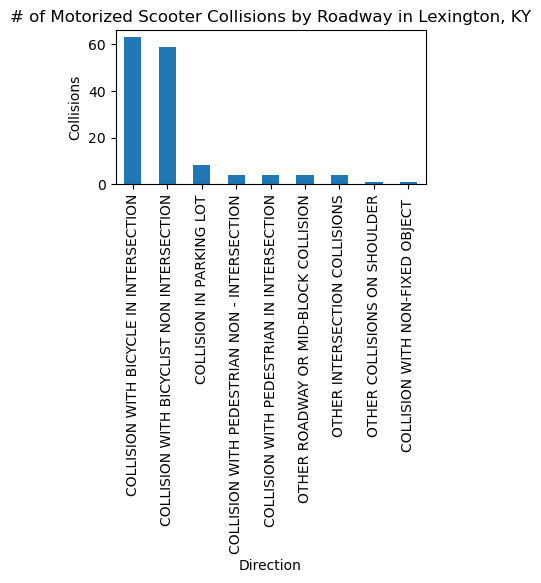

In [54]:
fig, ax = plt.subplots(figsize=(4,2))
all_bicycle['DIRECTIONAL ANALYSIS'].value_counts().plot.bar()
ax.set_xlabel('Direction')
ax.set_ylabel('Collisions' )
ax.set_title('# of Motorized Scooter Collisions by Roadway in Lexington, KY')



In [31]:
all_bicycle.MANNER.value_counts()

SINGLE VEHICLE    148
Name: MANNER, dtype: int64

In [32]:
all_bicycle.ROADWAY.value_counts()

NEW CIRCLE            14
BROADWAY              12
LIMESTONE              6
NICHOLASVILLE          5
EUCLID                 5
WINCHESTER             4
RICHMOND               3
VERSAILLES             3
NEWTOWN                3
ROSE                   3
ALEXANDRIA             3
LOUDON                 2
7TH                    2
HARRODSBURG            2
MAN O WAR              2
RED MILE               2
BULL LEA               2
VIRGINIA               2
MAIN                   2
HIGH                   2
TATES CREEK            2
KENESAW                2
WOODHILL               2
ELM TREE               2
FOREMAN                1
SUNSET                 1
FEATHERSTON            1
TRADE                  1
GRASSY CREEK           1
SHORT                  1
CONSTITUTION           1
MARBLEHEAD             1
ANNISTON               1
KEITHSHIRE             1
DEER CROSSING          1
BUCKHORN               1
GEORGETOWN             1
NEWTOWN SPRINGS        1
LOCUST                 1
MIDLAND                1


<AxesSubplot:>

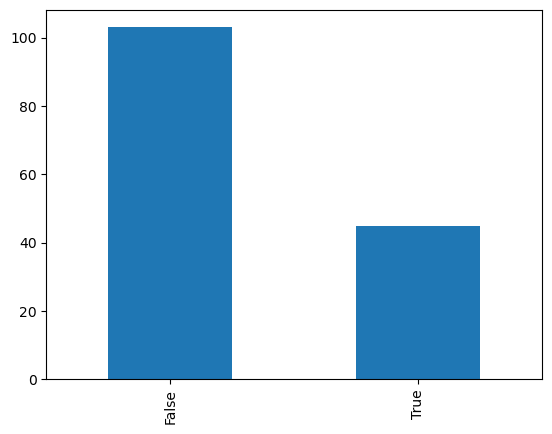

In [55]:
# Let's check hit and runs like we did with scooters

all_bicycle['H&R'].value_counts().plot.bar()

In [ ]:
# Wow! Hit and runs are more common among scooters than bicycles here in Lexington. 

Text(0.5, 1.0, '# of Motorized Scooter Collisions by Roadway in Lexington, KY')

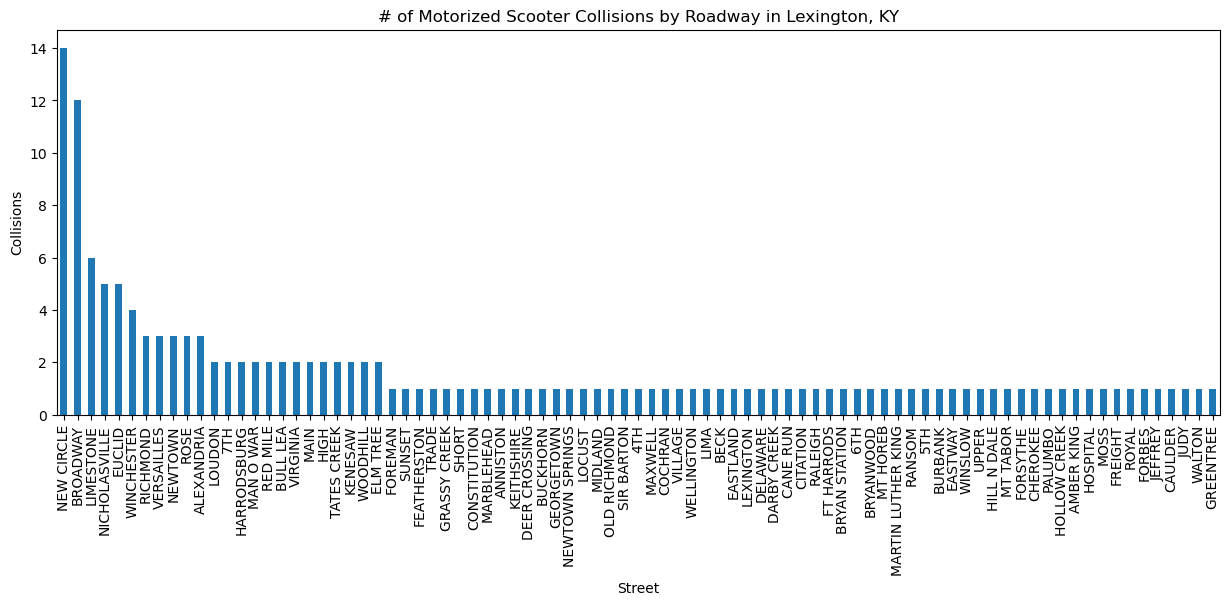

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))
all_bicycle.ROADWAY.value_counts().plot.bar()
ax.set_xlabel('Street',)
ax.set_ylabel('Collisions' )
ax.set_title('# of Motorized Scooter Collisions by Roadway in Lexington, KY')

New Circle, Broadway, and Limestone are still considerably dangerous for both bicycles and scooters. However, notice that Tates Creek Road is 2oth on this list. It has the highest number of collisions for scooters, but is considerably lower when it comes to bicycles. This might be interesting to point out in the web map. 

## Bicycle Narrative Search Database 

In [56]:
bicycle_collisions_narrative

,"COLLISION NARRATIVE SEARCH RESULTS BASED ON THE KEYWORD ""SCOOTER"": JUNE 1, 2019 - JUNE 30, 2022",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,MFN,DATE,TIME,DOW,STR#,DIR,ROADWAY,SUF,MP,LATITUDE,LONGITUDE,INTERSECTION,#UNITS,#VEH#,#KILL,#INJURED,WEATHER,RD\COND,H&R,DIRECTIONAL ANALYSIS,MANNER,RDCHAR,LIGHT COND
1,72375575,7/4/19,1814,Thursday,NaN,NaN,VILLAGE,DR,0.311,38.04887251,-84.54921499,DEVONPORT DR,2,2,0,1,CLEAR,DRY,true,ANGLE COLLISION - OTHER,ANGLE,STRAIGHT & LEVEL,DAYLIGHT
2,72387418,8/1/19,0814,Thursday,NaN,NaN,ALUMNI,DR,1.825,38.00716915,-84.48722702,OLD MT TABOR RD,2,2,0,0,CLEAR,DRY,false,OPPOSING LEFT TURN,OPPOSING LEFT TURN,CURVE & GRADE,DAYLIGHT
3,72392613,8/13/19,1248,Tuesday,NaN,NaN,LIBERTY,RD,0.67,38.03499327,-84.46120239,NaN,1,1,0,1,CLEAR,DRY,false,COLLISION WITH FIXED OBJECT NON - INTERSECTION - FIRST EVENT COLLISION 09 - 32 EXCLUDING 16,SINGLE VEHICLE,STRAIGHT & GRADE,DAYLIGHT
4,72419029,10/10/19,1943,Thursday,NaN,NaN,PINE,ST,0.075,38.04346996,-84.50320753,UPPER ST,2,2,0,2,CLEAR,DRY,false,OPPOSING LEFT TURN,OPPOSING LEFT TURN,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON
5,72425069,10/23/19,1518,Wednesday,NaN,NaN,VIRGINIA,AVE,0.024,38.0350012,-84.50874376,NaN,2,2,0,0,CLEAR,DRY,true,HEAD-ON COLLISION,HEAD ON,STRAIGHT & LEVEL,DAYLIGHT
6,72425550,10/24/19,1147,Thursday,NaN,NaN,MANCHESTER,ST,7.603,38.05227767,-84.50826297,OLIVER LEWIS WAY,2,2,0,0,CLEAR,DRY,false,REAR END - ONE VEHICLE TURNING LEFT,REAR END,STRAIGHT & LEVEL,DAYLIGHT
7,72447760,12/8/19,0212,Sunday,NaN,E,VINE,ST,13.849,38.04495615,-84.49747054,NaN,2,2,0,0,CLEAR,DRY,true,SIDESWIPE COLLISION - SAME DIRECTION,SIDESWIPE-SAME DIRECTION,STRAIGHT & LEVEL,DARK-HWY LIGHTED/ON
8,72450444,12/13/19,1125,Friday,NaN,NaN,TRANSYLVANIA,PARK,0.28,38.03751233,-84.49467869,MAXWELL ST,2,1,0,1,CLOUDY,DRY,false,COLLISION WITH PEDESTRIAN IN INTERSECTION,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT
9,72481872,2/28/20,1500,Friday,NaN,W,LOUDON,AVE,0.23,38.05979338,-84.48434366,BROADWAY,2,1,0,1,CLOUDY,DRY,true,OTHER INTERSECTION COLLISIONS,SINGLE VEHICLE,STRAIGHT & LEVEL,DAYLIGHT
